In [14]:
import os
import sys
import random
import math
import re
import time
import numpy as np
import cv2
import matplotlib
import matplotlib.pyplot as plt
import pathlib
import skimage
import imgaug
from imgaug import augmenters as iaa
from PIL import Image
from skimage.filters import threshold_otsu
ROOT_DIR = os.path.abspath("../")
sys.path.append(ROOT_DIR)  # To find local version of the library
from mrcnn.config import Config
from mrcnn import utils
import mrcnn.model as modellib
from mrcnn import visualize
from mrcnn.model import log
MODEL_DIR = os.path.join(ROOT_DIR, "logs")
COCO_MODEL_PATH = os.path.join(ROOT_DIR, "mask_rcnn_coco.h5")

In [15]:
# minimum input size = 128
class ShapesConfig(Config):
    # Give the configuration a recognizable name
    NAME = "skin_stephen"
    GPU_COUNT = 1

    ##
    IMAGES_PER_GPU = 32
    ##

    NUM_CLASSES = 1 + 2  # background + 2 types
    IMAGE_MIN_DIM = 128
    IMAGE_MAX_DIM = 128
    RPN_ANCHOR_SCALES = (16,32,64,128,256)  # anchor side in pixels
    TRAIN_ROIS_PER_IMAGE = 8

    ##
    # number of images in your dataset goes in here
    # training
    STEPS_PER_EPOCH = 8696 // IMAGES_PER_GPU
    # validation
    VALIDATION_STEPS = 1250 // IMAGES_PER_GPU
    ##

    LEARNING_RATE = 0.001
    USE_MINI_MASK = False
    # gpu_options = True
config = ShapesConfig()
def get_ax(rows=1, cols=1, size=8):
    _, ax = plt.subplots(rows, cols, figsize=(size*cols, size*rows))
    return ax

class ShapesDataset(utils.Dataset):
    def list_images(self,data_dir):
        # define classes
        self.add_class("skin", 1, "fibroblast")
        self.add_class("skin", 2, "falsePositive")

        train_images = list(data_dir.glob('*tile*/image/*.png'))
        print('# image in this dataset : ',len(train_images))
        for idx,train_image in enumerate(train_images):
            label = str(train_image).replace("image","mask")
            self.add_image("skin",image_id=idx,path=train_image,labelpath=label,
                           height=config.IMAGE_SHAPE[0],width=config.IMAGE_SHAPE[1])

        train_images = list(data_dir.glob('*false_positive*/image/*.png'))
        print('# image in this dataset : ',len(train_images))
        for idxx,train_image in enumerate(train_images):
            label = str(train_image).replace("image","mask")
            self.add_image("skin",image_id=idx+idxx,path=train_image,labelpath=label,
                           height=config.IMAGE_SHAPE[0],width=config.IMAGE_SHAPE[1])

    def load_image(self, image_id):
        """Load the specified image and return a [H,W,3] Numpy array.
        """
        # Load image
        image = skimage.io.imread(self.image_info[image_id]['path'])
        # If grayscale. Convert to RGB for consistency.
        if image.ndim != 3:
            print('grayscale to rgb')
            image = skimage.color.gray2rgb(image)
        # If has an alpha channel, remove it for consistency
        if image.shape[-1] == 4:
            print('rgba to rgb')
            image = image[..., :3]
        # image = cv2.resize(image,dsize=(256,256))
        return image.astype(np.uint8)

    # def load_mask(self, image_id):
    #     label = self.image_info[image_id]['labelpath']
    #     mask = np.load(label.replace('.tif','mask.npy'))
    #     class_ids = np.load(label.replace('.tif','classids.npy'))
    #     class_ids = class_ids + 1
    #     return mask,class_ids

    def load_mask(self, image_id):
        label = self.image_info[image_id]['labelpath']
        mask = Image.open(label)
        mask = np.array(mask).astype('int')
        mask = mask[:,:,np.newaxis]
        if 'false_positive' in label:
            class_ids = np.array([2])
        else:
            class_ids = np.array([1])
        return mask,class_ids


    def image_reference(self, image_id):
        """Return the shapes data of the image."""
        info = self.image_info[image_id]
        if info["source"] == "skin":
            return info["truth"]
        else:
            super(self.__class__).image_reference(self, image_id)

In [16]:
## train set path
data_dir = pathlib.Path(r'\\motherserverdw\Kyu_Sync\server for undergrads\Stephen\train')
##
dataset_train = ShapesDataset()
dataset_train.list_images(data_dir)
dataset_train.prepare()

# image in this dataset :  1832
# image in this dataset :  6864


In [17]:
## validation set path
data_dir_val = pathlib.Path(r'\\motherserverdw\Kyu_Sync\server for undergrads\Stephen\validation')
##
dataset_val = ShapesDataset()
dataset_val.list_images(data_dir_val)
dataset_val.prepare()


## run upto here to check the number of images in training and validation set
## ex) 1832+6864 training set =8696  ;  331+919 validation set =1250
## put these number at the very top of this script

# image in this dataset :  331
# image in this dataset :  919


In [18]:
image_ids = np.random.choice(dataset_train.image_ids, 5)
for image_id in image_ids:
    image = dataset_train.load_image(image_id)
    mask, class_ids = dataset_train.load_mask(image_id)
    print(class_ids)

[2]
[2]
[2]
[2]
[2]


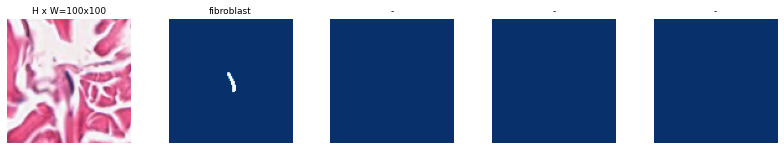

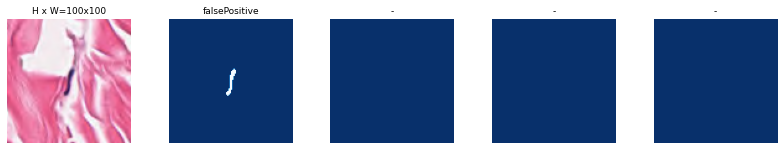

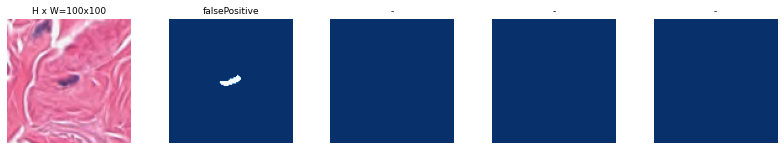

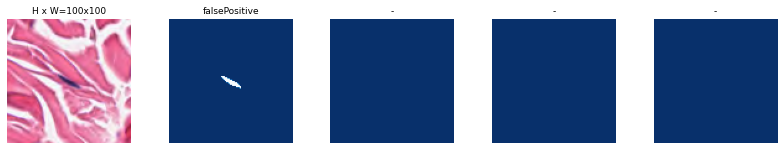

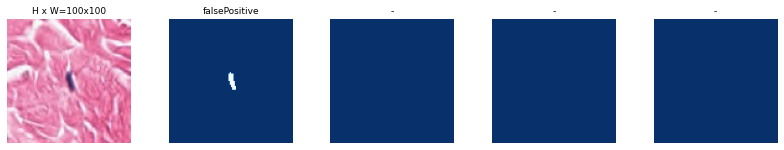

In [19]:
# example image and mask pairs
image_ids = np.random.choice(dataset_val.image_ids, 5)
for image_id in image_ids:
    image = dataset_val.load_image(image_id)
    mask, class_ids = dataset_val.load_mask(image_id)
    visualize.display_top_masks(image, mask, class_ids, dataset_val.class_names)

In [20]:
dataset_val.image_info[image_id]

{'id': 944,
 'source': 'skin',
 'path': WindowsPath('//motherserverdw/Kyu_Sync/server for undergrads/Stephen/validation/Wirtz.Denis_OTS-19_5021-003_false_positive_4/image/tile_2.png'),
 'labelpath': '\\\\motherserverdw\\Kyu_Sync\\server for undergrads\\Stephen\\validation\\Wirtz.Denis_OTS-19_5021-003_false_positive_4\\mask\\tile_2.png',
 'height': 128,
 'width': 128}

In [21]:
# Add augmentation and mask resizing.
image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
    dataset_train, config, image_id,
    augmentation=imgaug.augmenters.Fliplr(0.5), use_mini_mask=False)

In [22]:
# Create model in training mode
model = modellib.MaskRCNN(mode="training", config=config,
                          model_dir=MODEL_DIR)

keras version 2.2.5
tf version 1.12.0
keras version 2.2.5
tf version 1.12.0


In [23]:
# Which weights to start with?
init_with = "coco"  # imagenet, coco, or last

if init_with == "imagenet":
    model.load_weights(model.get_imagenet_weights(), by_name=True)
elif init_with == "coco":
    # Load weights trained on MS COCO, but skip layers that
    # are different due to the different number of classes
    # See README for instructions to download the COCO weights
    model.load_weights(COCO_MODEL_PATH, by_name=True,
                       exclude=["mrcnn_class_logits", "mrcnn_bbox_fc",
                                "mrcnn_bbox", "mrcnn_mask"])
elif init_with == "last":
    # Load the last model you trained and continue training
    model.load_weights(model.find_last(), by_name=True)

## Training

Train in two stages:
1. Only the heads. Here we're freezing all the backbone layers and training only the randomly initialized layers (i.e. the ones that we didn't use pre-trained weights from MS COCO). To train only the head layers, pass `layers='heads'` to the `train()` function.

2. Fine-tune all layers. For this simple example it's not necessary, but we're including it to show the process. Simply pass `layers="all` to train all layers.

In [24]:
augmentation = iaa.Sometimes(0.9, [
    iaa.color.AddToHueAndSaturation((-10,10)),
    iaa.Fliplr(0.5),
    iaa.Flipud(0.5),
    iaa.OneOf([iaa.Affine(rotate=90),
                   iaa.Affine(rotate=180),
                   iaa.Affine(rotate=270)]),
    iaa.Multiply((0.8, 1.2)),
    iaa.GaussianBlur(sigma=(0.0, 1.0)),
])

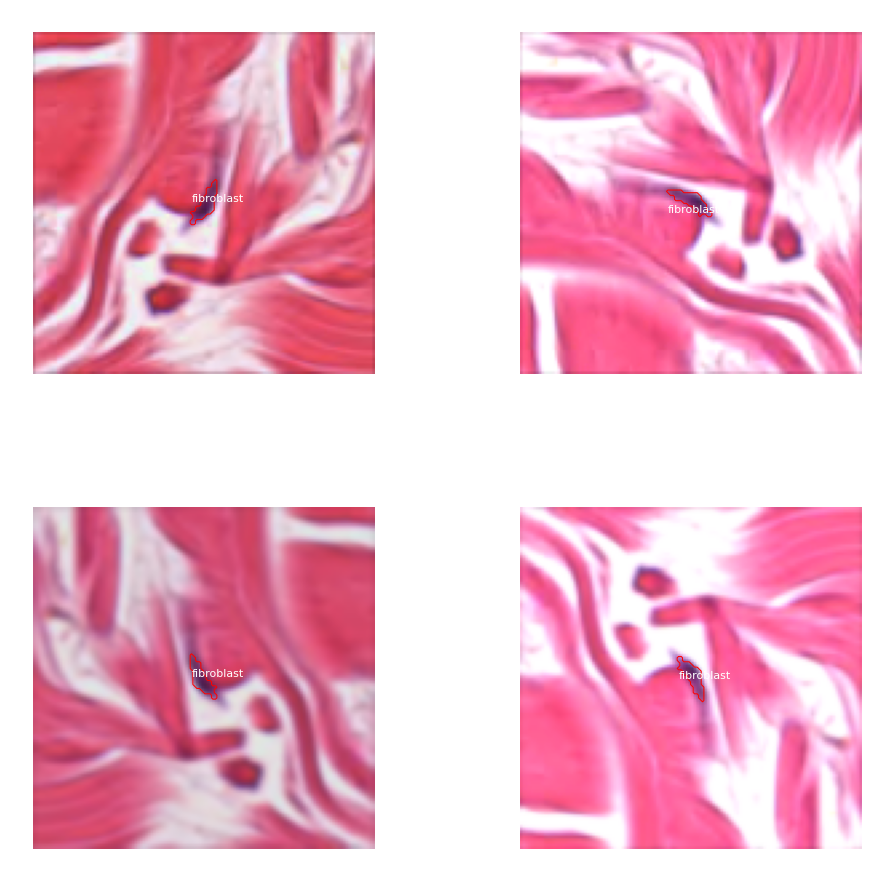

In [25]:
## display example image augmentation
limit = 4
ax = get_ax(rows=2, cols=limit//2)
for i in range(limit):
    image, image_meta, class_ids, bbox, mask = modellib.load_image_gt(
        dataset_train, config, image_id, use_mini_mask=False, augment=False, augmentation=augmentation)
    visualize.display_instances(image, bbox, mask, class_ids,
                                dataset_train.class_names, ax=ax[i//2, i % 2],
                                show_mask=False, show_bbox=False)

In [26]:
# Train the head branches

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE,
            ## change number of epochs to run training
            epochs=20,
            ##
            augmentation=augmentation,
            layers='heads')


Starting at epoch 0. LR=0.001

Checkpoint Path: C:\Users\kuki\PycharmProjects\Mask_RCNN\logs\skin_stephen20201101T0139\mask_rcnn_skin_stephen_{epoch:04d}.h5
Selecting layers to train
fpn_c5p5               (Conv2D)
fpn_c4p4               (Conv2D)
fpn_c3p3               (Conv2D)
fpn_c2p2               (Conv2D)
fpn_p5                 (Conv2D)
fpn_p2                 (Conv2D)
fpn_p3                 (Conv2D)
fpn_p4                 (Conv2D)
In model:  rpn_model
    rpn_conv_shared        (Conv2D)
    rpn_class_raw          (Conv2D)
    rpn_bbox_pred          (Conv2D)
mrcnn_mask_conv1       (TimeDistributed)
mrcnn_mask_bn1         (TimeDistributed)
mrcnn_mask_conv2       (TimeDistributed)
mrcnn_mask_bn2         (TimeDistributed)
mrcnn_class_conv1      (TimeDistributed)
mrcnn_class_bn1        (TimeDistributed)
mrcnn_mask_conv3       (TimeDistributed)
mrcnn_mask_bn3         (TimeDistributed)
mrcnn_class_conv2      (TimeDistributed)
mrcnn_class_bn2        (TimeDistributed)
mrcnn_mask_conv4     

c:\users\kuki\anaconda3\envs\aging\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "


In [27]:
# Fine tune all layers

model.train(dataset_train, dataset_val,
            learning_rate=config.LEARNING_RATE / 10,
            ## change number of epochs to run training
            ## CAREFUL: epoch number is cumulative
            ## the actual number of epoch for fine tuning is 25-20=5
            epochs=25,
            ## change number of epochs to run training
            augmentation=imgaug.augmenters.Fliplr(0.5),
            layers="all")

## after this script is finished go to evaluate.ipynb


Starting at epoch 20. LR=0.0001

Checkpoint Path: C:\Users\kuki\PycharmProjects\Mask_RCNN\logs\skin_stephen20201101T0139\mask_rcnn_skin_stephen_{epoch:04d}.h5
Selecting layers to train
conv1                  (Conv2D)
bn_conv1               (BatchNorm)
res2a_branch2a         (Conv2D)
bn2a_branch2a          (BatchNorm)
res2a_branch2b         (Conv2D)
bn2a_branch2b          (BatchNorm)
res2a_branch2c         (Conv2D)
res2a_branch1          (Conv2D)
bn2a_branch2c          (BatchNorm)
bn2a_branch1           (BatchNorm)
res2b_branch2a         (Conv2D)
bn2b_branch2a          (BatchNorm)
res2b_branch2b         (Conv2D)
bn2b_branch2b          (BatchNorm)
res2b_branch2c         (Conv2D)
bn2b_branch2c          (BatchNorm)
res2c_branch2a         (Conv2D)
bn2c_branch2a          (BatchNorm)
res2c_branch2b         (Conv2D)
bn2c_branch2b          (BatchNorm)
res2c_branch2c         (Conv2D)
bn2c_branch2c          (BatchNorm)
res3a_branch2a         (Conv2D)
bn3a_branch2a          (BatchNorm)
res3a_bran

c:\users\kuki\anaconda3\envs\aging\lib\site-packages\tensorflow\python\ops\gradients_impl.py:112: UserWarning: Converting sparse IndexedSlices to a dense Tensor of unknown shape. This may consume a large amount of memory.
  "Converting sparse IndexedSlices to a dense Tensor of unknown shape. "
